# Importing the libraries required

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# Fetching the dataset

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2020-12-02 12:16:02--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2020-12-02 12:16:03--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.97.72
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 949267727 (905M) [application

In [ ]:
!unzip file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  infl

# Building the model

In [ ]:
IMAGE_SIZE = 224

In [ ]:
vgg = VGG16(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model = Sequential()

In [ ]:
for layer in vgg.layers:
  model.add(layer)

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
DATA_DIR = '/content/Plant_leave_diseases_dataset_with_augmentation'
CATEGORIES = os.listdir(path=DATA_DIR)

In [ ]:
model.add(Flatten(name='flatten'))
model.add(Dense(units=len(CATEGORIES), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Preprocessing

In [ ]:
BATCH_SIZE = 128

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(directory='/content/Plant_leave_diseases_dataset_with_augmentation', 
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              color_mode='rgb', 
                                              class_mode='categorical', 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              subset='training')

test_generator = datagen.flow_from_directory(directory='/content/Plant_leave_diseases_dataset_with_augmentation', 
                                              target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              color_mode='rgb', 
                                              class_mode='categorical', 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=False, 
                                              subset='validation')

Found 49197 images belonging to 39 classes.
Found 12289 images belonging to 39 classes.


# Training the model

In [ ]:
EPOCHS = 25

In [ ]:
history = model.fit(x=train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size)

In [ ]:
results = model.evaluate(x=test_generator)

97/97 [==============================] - 30s 305ms/step - loss: 0.1681 - accuracy: 0.9661


In [ ]:
print(f'Validation Loss: {results[0]}')
print(f'Validation Accuracy: {results[1]}')

[0.16814929246902466, 0.9660671949386597]

# Saving the model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_name = 'model_cs391'
file_path = f'/content/gdrive/My Drive/Design Project/{model_name}'

In [ ]:
model.save(file_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Design Project/model_21_10_vgg16_tops_false_yes_dropout_128bs_50e/assets


# Loading the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_name = 'vgg16_includeTopsFalse_noDropout_batchSize128_epochs25'
file_path = f'/content/gdrive/My Drive/Design Project/{model_name}'

In [ ]:
model = load_model(file_path)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# Predictions and model performance evaluation

#### Predicting class of a single image from the test dataset

In [ ]:
img_path = '/content/Plant_leave_diseases_dataset_with_augmentation/Corn___Common_rust/image (101).JPG'

In [ ]:
img = cv2.imread(img_path)  # converts the image into a numerical matrix

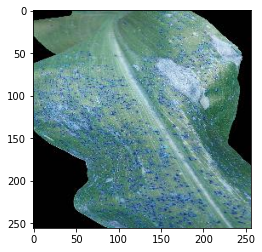

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.reshape(img, [1, IMAGE_SIZE, IMAGE_SIZE, 3])
img = img/255.

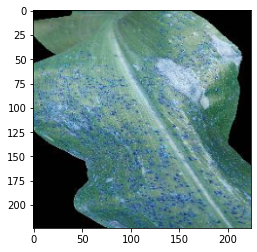

In [ ]:
plt.imshow(np.reshape(img, [IMAGE_SIZE, IMAGE_SIZE, 3]))
plt.show()

In [ ]:
class_confidence = model.predict(x=img)   # provides an array of predictions for each class

In [ ]:
class_index = int(np.argmax(class_confidence, axis=1))    # finds the array index of the class with the highest prediction confidence value

In [ ]:
class_index

9

In [ ]:
classes = [x for x in test_generator.class_indices.keys()]
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

In [ ]:
classes[class_index]

'Corn___Common_rust'

In [ ]:
class_confidence = np.squeeze(class_confidence)   # removes redundant array dimensions

In [ ]:
class_confidence

array([3.86937707e-20, 1.18461167e-29, 3.93065450e-28, 2.82992830e-25,
       7.37159159e-25, 4.27075153e-30, 2.77657329e-22, 5.68569824e-21,
       1.37489263e-13, 1.00000000e+00, 1.52357715e-18, 3.27326739e-27,
       3.12354127e-34, 3.24975613e-25, 3.17685010e-25, 7.16262374e-29,
       1.35268118e-17, 2.41245517e-24, 1.04300785e-26, 1.18615238e-16,
       8.54327489e-17, 3.15214105e-24, 1.14471094e-20, 1.52492372e-21,
       7.15961869e-29, 5.40238403e-22, 1.01053305e-17, 1.06576181e-23,
       3.24356275e-18, 9.08689306e-22, 4.22124765e-14, 6.90099063e-12,
       5.23891739e-18, 6.50877405e-20, 7.60830319e-29, 1.78550437e-29,
       7.84722207e-19, 1.30400544e-25, 1.46905992e-26], dtype=float32)

In [ ]:
class_confidence.shape

(39,)

In [ ]:
class_confidence[class_index] * 100

100.0

#### Predicting classes for the test dataset

In [ ]:
pred = model.predict(x=test_generator)

In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
pred

array([ 0,  0,  0, ..., 38, 38, 38])

In [ ]:
len(pred)

12289

#### Model performance evaluation

In [ ]:
print('Confusion Matrix:\n')
print(confusion_matrix(y_true=test_generator.classes, y_pred=pred))
print('\n\n')
print('Classification Report:\n')
print(classification_report(y_true=test_generator.classes, y_pred=pred))

Confusion Matrix:

[[ 190    0    0 ...    0    0    0]
 [   0  198    0 ...    0    0    0]
 [   1    0  197 ...    0    0    0]
 ...
 [   0    0    0 ... 1061    1    0]
 [   0    0    0 ...    0  187    0]
 [   0    0    0 ...    0    0  315]]



Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       200
           1       0.99      0.99      0.99       200
           2       0.98      0.98      0.98       200
           3       0.96      0.97      0.96       329
           4       0.97      0.96      0.97       228
           5       0.99      0.99      0.99       300
           6       1.00      0.99      0.99       210
           7       1.00      0.99      0.99       200
           8       0.89      0.85      0.87       200
           9       1.00      0.99      0.99       238
          10       0.84      0.90      0.86       200
          11       0.99      0.98      0.98       232
          12       0.97